# This notebook validates trained BuDDI4 models on whether the sample id latnet space informs decoding and is sufficiently disentangled from the other latent spaces, for the bulk RNA-seq data

In [1]:
import joblib
import sys
import pathlib
import yaml
import subprocess

In [2]:
CELL_TYPE_COL = 'encode_celltype'
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
TECH_COL = 'samp_type'
DATASPLIT_COL = 'isTraining'

GENE_ID_COL = 'gene_ids'

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

In [4]:
buddi_fork_path = config_dict['software_path']['buddi_v2']
buddi_fork_path = pathlib.Path(buddi_fork_path)
assert buddi_fork_path.exists(), f"buddi fork not found at {buddi_fork_path}"

sys.path.append(str(REPO_ROOT))
sys.path.append(str(buddi_fork_path))
# this is quite ugly, once activate modifications are done this will be changed
# to a proper installation + import
from buddi_v2.models.buddi4_class import BuDDI4

2025-05-13 15:10:17.677205: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 15:10:17.687130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747170617.697425 2449103 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747170617.700696 2449103 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747170617.709772 2449103 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Define paths to Input Files/Output

### Input from pre-processing

In [5]:
PREPROCESSING_OUTPUT_PATH = REPO_ROOT / 'processed_data' 
buddi4_data_file = PREPROCESSING_OUTPUT_PATH / 'buddi4_data.pkl'
assert buddi4_data_file.exists(), f"Train data file not found at {buddi4_data_file}"

### Trained model save path

In [6]:
TRAINED_MODELS_PATH = REPO_ROOT / 'trained'
model_folders = sorted(TRAINED_MODELS_PATH.glob('buddi4_*'))
assert len(model_folders) > 0, f"No trained models found in {TRAINED_MODELS_PATH}"

In [7]:
filtered_model_folders = [
    folder for folder in model_folders if 'label_beta=1.0;' in str(folder)
]
[
    folder.parts[-1] for folder in filtered_model_folders
]

['buddi4_3a0f7eac;beta=100.0;label_beta=1.0;slack_beta=0.1',
 'buddi4_978119ce;beta=100.0;label_beta=1.0;slack_beta=0.1',
 'buddi4_a08b0de0;beta=10.0;label_beta=1.0;slack_beta=0.1',
 'buddi4_ad103b58;beta=1.0;label_beta=1.0;slack_beta=0.1',
 'buddi4_e3248280;beta=1.0;label_beta=1.0;slack_beta=0.1',
 'buddi4_fa9bbf43;beta=10.0;label_beta=1.0;slack_beta=0.1']

## Load Data

In [8]:
buddi4_data = joblib.load(buddi4_data_file)
print(buddi4_data)
print('\n')

n_x = len(buddi4_data.gene_names)
n_y = len(buddi4_data.cell_type_names)
n_labels = buddi4_data.encode_meta[SAMPLE_ID_COL].shape[1]
n_stims = buddi4_data.encode_meta[STIM_COL].shape[1]
n_samp_types = buddi4_data.encode_meta[TECH_COL].shape[1]
print(f"Number of genes: {n_x}")
print(f"Number of cell types: {n_y}")
print(f"Number of unique labels: {n_labels}")
print(f"Number of unique stimulations: {n_stims}")
print(f"Number of unique sample types: {n_samp_types}")

BuDDI4Data(total_samples=8988, genes=7000, cell_types=11)


Number of genes: 7000
Number of cell types: 11
Number of unique labels: 593
Number of unique stimulations: 2
Number of unique sample types: 2


In [9]:
obj = BuDDI4.load(
    filtered_model_folders[0] 
)
print(obj.encoders)
print(obj.decoder)
print(obj.prop_estimator)

I0000 00:00:1747170621.290389 2449103 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4817 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


{'label': <Functional name=encoder_label, built=True>, 'stim': <Functional name=encoder_stim, built=True>, 'samp_type': <Functional name=encoder_samp_type, built=True>, 'slack': <Functional name=encoder_slack, built=True>}
<Functional name=shared_X_decoder, built=True>
<Functional name=prop_estimator, built=True>


In [10]:
from analysis_utils.validation.perturb_sample import perturb_bulk_sample
from analysis_utils.validation.resample import reconstruct
from analysis_utils.validation.plot_perturb import plot_perturb_reduction

In [11]:
x_reconst_sample_perturb, sample_perturb_meta = perturb_bulk_sample(
    obj,
    data=buddi4_data,
    n_subsamples=5, # 5 samples
    n_resamples=100,
    seed=42
)

Perturbing label ...:   0%|          | 0/5 [00:00<?, ?it/s]

Perturbing label ...: 100%|██████████| 5/5 [00:41<00:00,  8.24s/it]


In [12]:
selected_samples = sample_perturb_meta['source'].unique()
selected_samples

array(['20160X39', '18341X44', '20160X31', '20160X133', '19291X305'],
      dtype=object)

In [13]:
recon_query = {'samp_type': 'bulk'}

x_reconstruct, meta_reconstruct = reconstruct(
    obj=obj,
    data=buddi4_data,
    n_subsamples=5,
    n_resamples=100,
    query_kwargs=recon_query,
    seed=42,
)

In [14]:
meta_reconstruct[SAMPLE_ID_COL].unique()

array(['20160X39', '18341X44', '20160X31', '20160X133', '19291X305'],
      dtype=object)

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


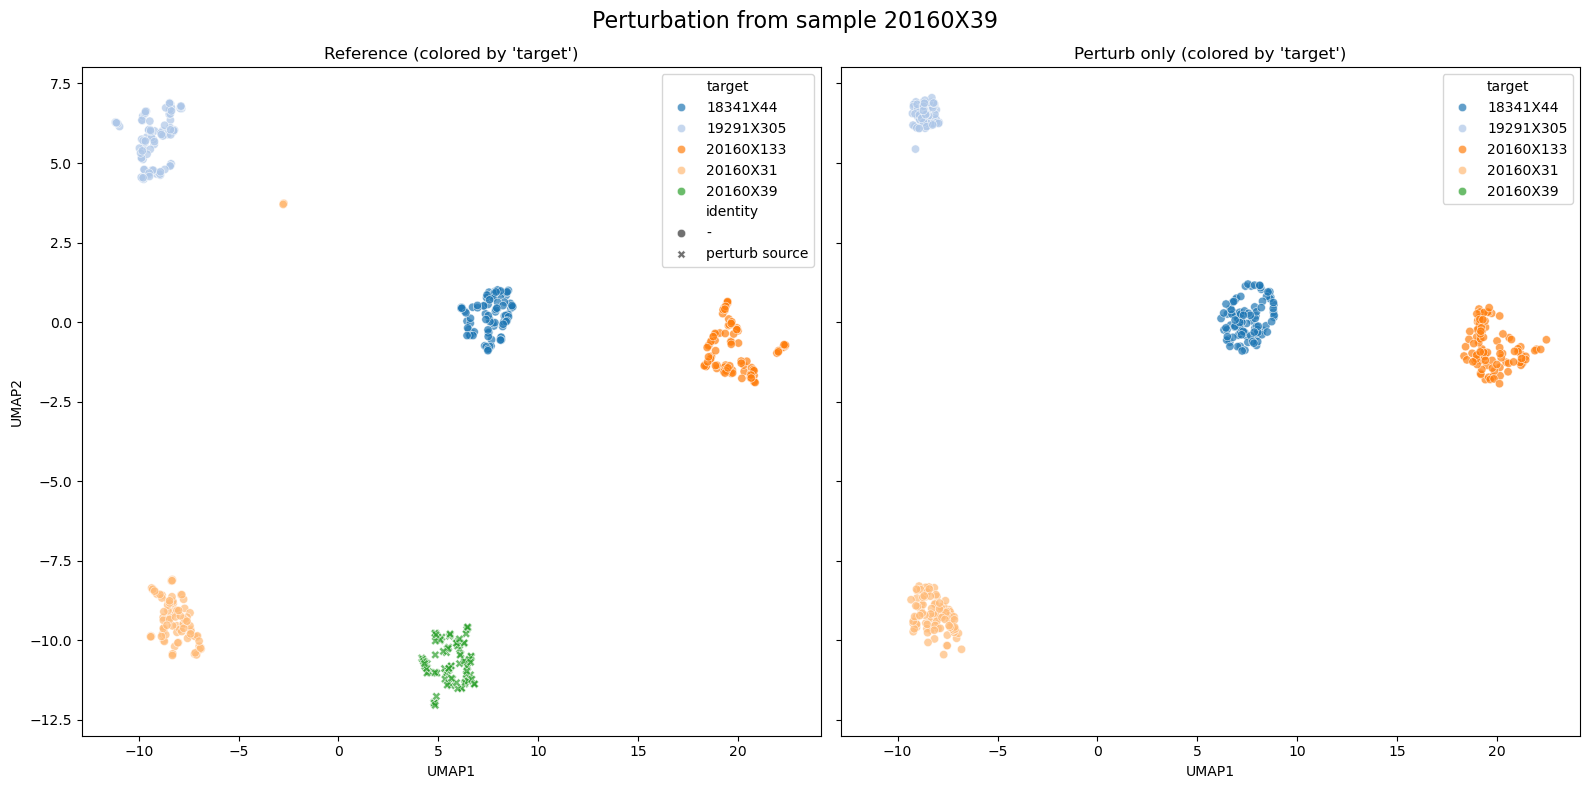

In [15]:
src_to_plot = selected_samples[0]

plot_perturb_reduction(
    x_basis=x_reconstruct,
    meta_basis=meta_reconstruct,
    x_perturb=x_reconst_sample_perturb,
    meta_perturb=sample_perturb_meta,
    filter_source=src_to_plot,
    filter_target=None,
    reduction_method='UMAP',
    reduction_random_state=42,
    panel_width=8,
    title=f'Perturbation from sample {src_to_plot}',
    show_plot=True,
    save_path=None
)